In [1]:
from google.colab import drive
import os

# 1. 드라이브 마운트
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 2. 경로 설정 (이미지 3번 캡처 기준)
DRIVE_ROOT = '/content/drive/MyDrive/cv2/plantseg_tomato'
LOCAL_ROOT = '/content/plantseg_tomato'

# 3. 로컬 폴더 구조 생성 (YOLO 표준: train/val)
for split in ['train', 'val']:
    for sub in ['images', 'labels']:
        os.makedirs(os.path.join(LOCAL_ROOT, split, sub), exist_ok=True)

print("✅ 드라이브 마운트 및 로컬 폴더 생성 완료")

In [ ]:
import shutil
from tqdm import tqdm

def sync_data(src_split, dest_split):
    # 이미지 복사 (Drive: images/train -> Local: train/images)
    src_img_path = os.path.join(DRIVE_ROOT, 'images', src_split)
    dest_img_path = os.path.join(LOCAL_ROOT, dest_split, 'images')

    imgs = [f for f in os.listdir(src_img_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    for img in tqdm(imgs, desc=f"Images ({src_split} -> {dest_split})"):
        shutil.copy(os.path.join(src_img_path, img), os.path.join(dest_img_path, img))

    # 라벨 복사 (Drive: annotations/train -> Local: train/labels)
    # ※ annotations 폴더 안에 .txt 파일이 있다고 가정함
    src_lbl_path = os.path.join(DRIVE_ROOT, 'annotations', src_split)
    dest_lbl_path = os.path.join(LOCAL_ROOT, dest_split, 'labels')

    if os.path.exists(src_lbl_path):
        lbls = os.listdir(src_lbl_path)
        for lbl in tqdm(lbls, desc=f"Labels ({src_split} -> {dest_split})"):
            shutil.copy(os.path.join(src_lbl_path, lbl), os.path.join(dest_lbl_path, lbl))

# 실행: Drive의 train/test를 Local의 train/val로 복사
sync_data('train', 'train')
sync_data('test', 'val')

Labels (test -> val): 100%|██████████| 181/181 [00:04<00:00, 39.72it/s] 


In [ ]:
import json
import os
from tqdm import tqdm

# 1. 클래스 매핑 (요청한 순서 그대로)
class_map = {
    'bacterial_leaf_spot': 0,
    'early_blight': 1,
    'late_blight': 2,
    'leaf_mold': 3,
    'septoria_leaf_spot': 4,
    'yellow_leaf_curl_virus': 5,
    'mosaic_virus': 6
}

DRIVE_JSON_ROOT = '/content/drive/MyDrive/cv2/plantseg_tomato/json'
LOCAL_ROOT = '/content/plantseg_tomato'

def convert_json_to_yolo(split, dest):
    src_dir = os.path.join(DRIVE_JSON_ROOT, split)
    dest_dir = os.path.join(LOCAL_ROOT, dest, 'labels')

    # 기존 라벨 폴더 비우기 (새로 정확하게 만들기 위해)
    if os.path.exists(dest_dir):
        import shutil
        shutil.rmtree(dest_dir)
    os.makedirs(dest_dir, exist_ok=True)

    json_files = [f for f in os.listdir(src_dir) if f.endswith('.json')]

    for f_name in tqdm(json_files, desc=f"Converting {split} JSON"):
        with open(os.path.join(src_dir, f_name), 'r') as f:
            data = json.load(f)

        # 이미지 크기 정보 (정규화를 위해 필요)
        h = data['imageHeight']
        w = data['imageWidth']

        yolo_lines = []
        for shape in data['shapes']:
            label = shape['label'].lower().replace(' ', '_')

            # 클래스 ID 찾기
            target_id = None
            for key, cid in class_map.items():
                if key in label:
                    target_id = cid
                    break

            if target_id is None: continue # 매칭 안 되면 스킵

            # 좌표 정규화 (x/W, y/H)
            points = shape['points']
            normalized_points = []
            for pt in points:
                normalized_points.append(round(pt[0] / w, 6))
                normalized_points.append(round(pt[1] / h, 6))

            line = f"{target_id} " + " ".join(map(str, normalized_points))
            yolo_lines.append(line)

        # TXT 파일로 저장
        txt_name = f_name.replace('.json', '.txt')
        with open(os.path.join(dest_dir, txt_name), 'w') as f:
            f.write("\n".join(yolo_lines))

# 실행: 드라이브 JSON -> 로컬 Labels
convert_json_to_yolo('train', 'train')
convert_json_to_yolo('test', 'val')

print("✅ JSON 기반 YOLO 라벨 생성이 완료되었습니다.")

Converting test JSON: 100%|██████████| 181/181 [00:10<00:00, 17.39it/s]

✅ JSON 기반 YOLO 라벨 생성이 완료되었습니다.


In [ ]:
import os

def check_counts(path):
    # 확인할 세부 폴더 (이미 설정한 경로)
    for s in ['train', 'val']:
        img_path = os.path.join(path, s, 'images')
        lbl_path = os.path.join(path, s, 'labels')

        # 폴더 존재 여부 확인
        if not os.path.exists(img_path) or not os.path.exists(lbl_path):
            print(f"⚠️ 경로를 찾을 수 없습니다: {s}")
            continue

        # 파일 개수 세기
        img_cnt = len(os.listdir(img_path))
        lbl_cnt = len(os.listdir(lbl_path))

        print(f"[{s}] 이미지: {img_cnt}개 | 라벨: {lbl_cnt}개")

        # 개수 불일치 시 경고 출력
        if img_cnt != lbl_cnt:
            print(f"  ❌ 경고: {s} 데이터의 이미지와 라벨 개수가 맞지 않습니다!")
        else:
            print(f"  ✅ {s} 데이터 개수 일치")

# 로컬 경로로 실행
check_counts('/content/plantseg_tomato')

[train] 이미지: 720개 | 라벨: 720개
  ✅ train 데이터 개수 일치
[val] 이미지: 181개 | 라벨: 181개
  ✅ val 데이터 개수 일치


In [ ]:
# 라벨 파일 하나 열어서 내용(좌표)이 있는지 확인
!head -n 1 /content/plantseg_tomato/train/labels/$(ls /content/plantseg_tomato/train/labels | head -n 1)

0 0.023603 0.328952 0.033832 0.311002 0.081039 0.27088 0.129819 0.225478 0.188041 0.169517 0.257278 0.119892 0.291896 0.136786 0.347758 0.136786 0.396538 0.114613 0.45712 0.091384 0.511408 0.093496 0.572777 0.100887 0.623918 0.133618 0.668765 0.163182 0.693155 0.199081 0.72856 0.226534 0.765539 0.232869 0.822974 0.206472 0.859166 0.186411 0.890637 0.199081 0.95122 0.228645 0.992132 0.258209 0.992132 0.276159 0.95122 0.312058 0.905586 0.335287 0.851298 0.347957 0.815106 0.361683 0.846577 0.408141 0.851298 0.433481 0.804878 0.396526 0.747443 0.381744 0.720692 0.372242 0.729347 0.35218 0.72856 0.328952 0.678993 0.29622 0.604249 0.269824 0.538946 0.278271 0.442958 0.335287 0.353265 0.397582 0.261998 0.448263 0.20771 0.468324 0.143981 0.468324 0.078678 0.428202 0.029111 0.390191 0.009441 0.342678 0.013375 0.325784 0.014162 0.323672 0.013375 0.318393


In [ ]:
import yaml

# 7개 클래스 순서 고정
data_config = {
    'path': '/content/plantseg_tomato', # 루트 경로
    'train': 'train/images',           # 학습 이미지 경로
    'val': 'val/images',               # 검증 이미지 경로
    'names': {
        0: 'Bacterial Leaf Spot',
        1: 'Early Blight',
        2: 'Late Blight',
        3: 'Leaf Mold',
        4: 'Septoria Leaf Spot',
        5: 'Yellow Leaf Curl Virus',
        6: 'Mosaic Virus'
    }
}

with open('/content/plantseg_tomato/data.yaml', 'w') as f:
    yaml.dump(data_config, f, sort_keys=False)

print("✅ data.yaml 파일이 /content/plantseg_tomato/ 경로에 생성되었습니다.")

✅ data.yaml 파일이 /content/plantseg_tomato/ 경로에 생성되었습니다.


In [ ]:
!pip install ultralytics -q

import ultralytics
from ultralytics import YOLO
import os
import shutil
import json
from tqdm import tqdm

ultralytics.checks()

Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Setup complete ✅ (12 CPUs, 167.1 GB RAM, 39.1/235.7 GB disk)


In [ ]:
import shutil
import os

# 1. 이전 학습 결과물 폴더 전체 삭제 (확실한 초기화)
if os.path.exists('/content/runs'):
    shutil.rmtree('/content/runs')
    print("✅ 기존 학습 폴더(runs)를 삭제했습니다. 이제 깨끗한 상태입니다.")

# 2. (선택사항) 다운로드된 모델 파일까지 새로 받고 싶다면
if os.path.exists('/content/yolo11l-seg.pt'):
    os.remove('/content/yolo11l-seg.pt')
    print("✅ 원본 모델 파일(.pt)을 삭제했습니다. 새로 다운로드됩니다.")

✅ 기존 학습 폴더(runs)를 삭제했습니다. 이제 깨끗한 상태입니다.
✅ 원본 모델 파일(.pt)을 삭제했습니다. 새로 다운로드됩니다.


In [ ]:
from ultralytics import YOLO

# 1. 모델 체급 변경 (Large -> Medium)
# 데이터가 적을 땐 작은 모델이 오히려 성능이 훨씬 잘 나옵니다.
model = YOLO('yolo11m-seg.pt')

# 2. 학습 실행 (강제 주입 모드)
results = model.train(
    data='/content/plantseg_tomato/data.yaml',
    epochs=150,             # 150번이면 충분합니다.
    imgsz=1024,             # 작은 점을 위해 해상도는 높게 유지
    batch=16,               # 배치 16 유지
    device=0,

    # --- [핵심 변경: 체급에 맞는 설정] ---
    optimizer='auto',       # SGD 자동 선택
    patience=0,             # [중요] 조기 종료 끔. 끝까지 학습 강제.

    # --- [작은 점 잡기 전략 유지] ---
    mosaic=0.5,             # 작은 객체 보호 (유지)
    close_mosaic=20,        # 후반 정밀도 향상 (유지)
    overlap_mask=True,      # 겹침 허용 (유지)

    # --- [과적합 방지] ---
    dropout=0.0,            # Medium 모델은 Large보다 과적합 위험이 적으므로 Dropout 제거 (순정 성능 확인)

    project='/content/runs',
    name='tomato_seg_v11M_final_resq', # 이름 변경: Medium Rescue
    exist_ok=True,
    pretrained=True
)

Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=20, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/plantseg_tomato/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m-seg.pt, momentum=0.937, mosaic=0.5, multi_scale=0.0, name=tomato_seg_v11M_final_resq, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, 

In [ ]:
# 1. 압축 실행 (경로 수정: v11L_reset_SGD -> v11M_final_resq)
!zip -r /content/tomato_seg_v11M_final_resq.zip /content/runs/tomato_seg_v11M_final_resq

# 2. 다운로드 실행 (압축 파일명 일치시킴)
from google.colab import files
files.download('/content/tomato_seg_v11M_final_resq.zip')

  adding: content/runs/tomato_seg_v11M_final_resq/ (stored 0%)
  adding: content/runs/tomato_seg_v11M_final_resq/MaskF1_curve.png (deflated 9%)
  adding: content/runs/tomato_seg_v11M_final_resq/BoxPR_curve.png (deflated 9%)
  adding: content/runs/tomato_seg_v11M_final_resq/train_batch5850.jpg (deflated 8%)
  adding: content/runs/tomato_seg_v11M_final_resq/MaskPR_curve.png (deflated 9%)
  adding: content/runs/tomato_seg_v11M_final_resq/val_batch0_pred.jpg (deflated 5%)
  adding: content/runs/tomato_seg_v11M_final_resq/labels.jpg (deflated 27%)
  adding: content/runs/tomato_seg_v11M_final_resq/val_batch1_labels.jpg (deflated 2%)
  adding: content/runs/tomato_seg_v11M_final_resq/confusion_matrix.png (deflated 18%)
  adding: content/runs/tomato_seg_v11M_final_resq/train_batch0.jpg (deflated 3%)
  adding: content/runs/tomato_seg_v11M_final_resq/train_batch5851.jpg (deflated 7%)
  adding: content/runs/tomato_seg_v11M_final_resq/weights/ (stored 0%)
  adding: content/runs/tomato_seg_v11M_fina

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 1. SAM2 설치 (시간이 조금 걸릴 수 있습니다)
!pip install -q git+https://github.com/facebookresearch/segment-anything-2.git

# 2. SAM2 체크포인트 다운로드 (Large 모델 사용 - 성능 최강)
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt

# 3. 필요한 라이브러리 임포트
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# GPU 설정 확인
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.5 MB/s eta 0:00:00
Using device: cuda


테스트 이미지: /content/plantseg_tomato/val/images/tomato_leaf_mold_google_0116.jpg
🔍 YOLO 추론 시작 (Threshold: 0.05)...
✅ 1개의 병반을 발견했습니다!
🎨 SAM2로 정밀 마스크 생성 중...


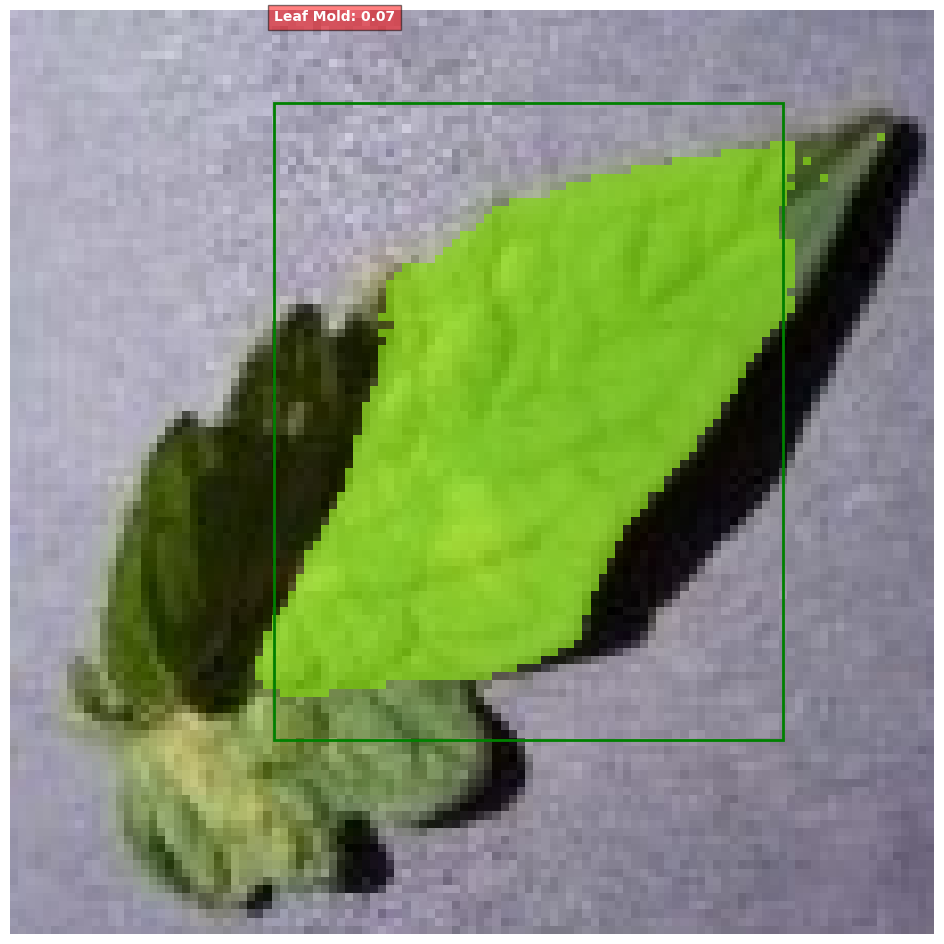

In [ ]:
# --- [수정된 함수] ---
def run_hybrid_segmentation(image_path, conf_threshold=0.1): # 기본값을 0.1로 낮춤
    # 1. 이미지 읽기
    image = cv2.imread(image_path)
    if image is None:
        print(f"이미지를 불러올 수 없습니다: {image_path}")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 2. YOLO로 박스(Box) 추출 (낮은 임계값 적용)
    print(f"🔍 YOLO 추론 시작 (Threshold: {conf_threshold})...")

    # verbose=False로 두되, 결과 객체는 받음
    yolo_results = yolo.predict(image_path, conf=conf_threshold, verbose=False)[0]

    # 박스가 없으면 종료하지 말고, 정보 출력
    if len(yolo_results.boxes) == 0:
        print("❌ YOLO가 병반을 찾지 못했습니다.")
        # 혹시 모르니 아주 낮은 점수로라도 잡힌 게 있었는지 확인하기 위해 0.01로 내부 테스트
        raw_check = yolo.predict(image_path, conf=0.01, verbose=False)[0]
        if len(raw_check.boxes) > 0:
            max_conf = raw_check.boxes.conf.max().item()
            print(f"   (참고: 임계값을 0.01로 낮추면 {len(raw_check.boxes)}개가 잡힙니다. 최고 점수: {max_conf:.4f})")
            print("👉 함수 호출 시 conf_threshold 값을 더 낮춰보세요.")
        return

    print(f"✅ {len(yolo_results.boxes)}개의 병반을 발견했습니다!")

    # YOLO 박스 좌표 가져오기
    boxes = yolo_results.boxes.xyxy.cpu().numpy()
    class_ids = yolo_results.boxes.cls.cpu().numpy()
    class_names = yolo_results.names

    # 3. SAM2 설정 및 추론
    print("🎨 SAM2로 정밀 마스크 생성 중...")
    predictor.set_image(image)

    masks, scores, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=boxes,
        multimask_output=False
    )

    # --- [3] 시각화 ---
    plt.figure(figsize=(12, 12))
    plt.imshow(image)

    for i, (mask, box, cls_id, score) in enumerate(zip(masks, boxes, class_ids, yolo_results.boxes.conf)):
        show_mask(mask, plt.gca(), random_color=True)
        show_box(box, plt.gca())

        # 라벨 + YOLO확신도 표시
        label = f"{class_names[int(cls_id)]}: {score:.2f}"
        plt.text(box[0], box[1]-10, label, color='white', fontsize=10, fontweight='bold',
                 bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

# --- [다시 실행] ---
# 가장 높은 확률로 하나 잡힌 이미지를 찾아서 넣으세요.
import glob
test_images = glob.glob('/content/plantseg_tomato/val/images/*.jpg')

if test_images:
    # 리스트의 첫 번째 이미지로 테스트하되, 임계값을 0.05(5%)까지 낮춰서 강제로 찾게 함
    target_img = test_images[0]
    print(f"테스트 이미지: {target_img}")
    run_hybrid_segmentation(target_img, conf_threshold=0.05)
else:
    print("테스트 이미지가 없습니다.")

🏥 토마토 종합 진단 시스템 V4 (Model-based Diagnosis) 가동 중...
✅ 생장 모델 로드 완료! (학습된 클래스 목록: {0: 'tomato'})
✅ 시스템 준비 완료!


📸 V4 재진단 시작: /content/drive/MyDrive/cv2/Laboro_Tomato/val/images/IMG_1011.jpg

       🍅 토마토 AI 진단 리포트 V4       
1️⃣ 생장 상태: ['Unknown (tomato)']
2️⃣ 질병 상태: ['Late Blight']


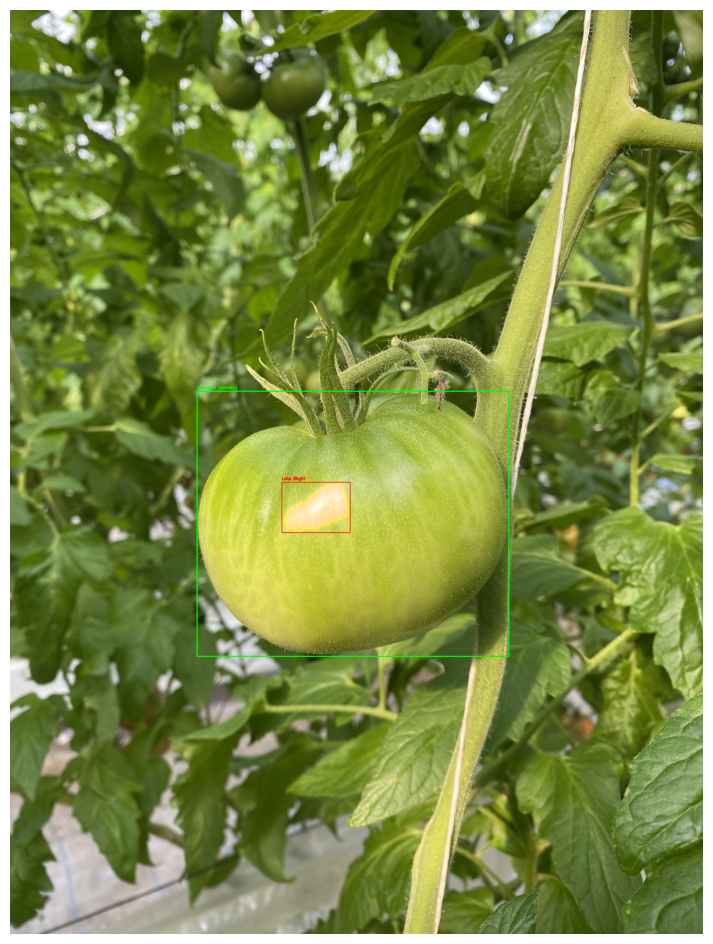

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

class TomatoDoctor:
    def __init__(self, laboro_path, plantseg_path, sam2_path, sam2_cfg, device='cuda'):
        print("🏥 토마토 종합 진단 시스템 V4 (Model-based Diagnosis) 가동 중...")
        self.device = device

        # 1. 생장 분석 모델 (Laboro)
        self.fruit_model = YOLO(laboro_path)

        # 🚨 [중요] 모델이 가진 클래스 이름 확인용 출력
        print(f"✅ 생장 모델 로드 완료! (학습된 클래스 목록: {self.fruit_model.names})")

        # 2. 질병 탐지 모델 (PlantSeg)
        self.disease_spotter = YOLO(plantseg_path)

        # 3. 정밀 진단 모델 (SAM2)
        try:
            sam2 = build_sam2(sam2_cfg, sam2_path, device=device)
            self.sam2_predictor = SAM2ImagePredictor(sam2)
        except Exception as e:
            print("⚠️ SAM2 모델 로드 실패!")
            raise e

        print("✅ 시스템 준비 완료!\n")

    def translate_ripeness(self, class_name):
        """
        Laboro 모델의 영문 클래스명을 요청하신 1, 2, 3 단계 한글로 변환합니다.
        (Laboro 데이터셋 원본 클래스명 기준)
        """
        name_lower = class_name.lower()

        # 3단계: 잘 익음 (완숙)
        if 'fully' in name_lower or 'ripe' in name_lower:
            return "3: 잘익음 (Ripe)"

        # 2단계: 덜 익음 (반숙)
        elif 'half' in name_lower or 'semi' in name_lower:
            return "2: 덜익음 (Semi)"

        # 1단계: 안 익음 (미숙)
        elif 'green' in name_lower or 'unripe' in name_lower:
            return "1: 안 익음 (Green)"

        # 예외: 모델이 그냥 'tomato'라고만 뱉을 경우
        return f"Unknown ({class_name})"

    def analyze(self, image_path, disease_conf=0.05):
        origin_img = cv2.imread(image_path)
        if origin_img is None: return None

        img_rgb = cv2.cvtColor(origin_img, cv2.COLOR_BGR2RGB)
        visual_img = origin_img.copy()

        report = {
            "fruit_status": [],
            "diseases_found": []
        }

        # ====================================================
        # [Step 1] 열매 생장 분석 (Laboro 모델 결과 그대로 사용)
        # ====================================================
        fruit_results = self.fruit_model.predict(origin_img, conf=0.35, verbose=False)[0]

        for box, cls_id in zip(fruit_results.boxes.xyxy.cpu().numpy(), fruit_results.boxes.cls.cpu().numpy()):
            # 모델이 뱉은 원래 클래스 이름 (예: b_green, l_fully_ripened)
            raw_name = fruit_results.names[int(cls_id)]

            # 한글로 변환 (1, 2, 3단계)
            korean_label = self.translate_ripeness(raw_name)
            report["fruit_status"].append(korean_label)

            # 박스 시각화
            x1, y1, x2, y2 = map(int, box)

            # 상태별 색상 지정
            color = (0, 255, 0) # 기본 초록
            if "3:" in korean_label: color = (0, 0, 255)    # 빨강
            elif "2:" in korean_label: color = (0, 165, 255) # 주황

            cv2.rectangle(visual_img, (x1, y1), (x2, y2), color, 3)
            cv2.putText(visual_img, korean_label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        # ====================================================
        # [Step 2] 질병 정밀 진단 (PlantSeg + SAM2)
        # ====================================================
        disease_results = self.disease_spotter.predict(origin_img, conf=disease_conf, verbose=False)[0]

        if len(disease_results.boxes) > 0:
            boxes = disease_results.boxes.xyxy.cpu().numpy()
            class_ids = disease_results.boxes.cls.cpu().numpy()
            class_names = disease_results.names

            self.sam2_predictor.set_image(img_rgb)
            masks, _, _ = self.sam2_predictor.predict(box=boxes, multimask_output=False)

            if masks.ndim == 4: masks = masks.squeeze(1)

            for i, (mask, box, cls_id) in enumerate(zip(masks, boxes, class_ids)):
                disease_name = class_names[int(cls_id)]
                report["diseases_found"].append(disease_name)

                if mask.ndim == 3: mask = mask.squeeze(0)

                # 질병 시각화 (진한 빨강 채우기 + 노란 실선)
                color_mask = np.zeros_like(visual_img)
                color_mask[mask > 0.0] = [0, 0, 255]
                visual_img = cv2.addWeighted(visual_img, 1.0, color_mask, 0.5, 0)

                # 외곽선(Contour)
                contours, _ = cv2.findContours((mask > 0.0).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                cv2.drawContours(visual_img, contours, -1, (0, 255, 255), 2)

                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(visual_img, (x1, y1), (x2, y2), (0, 0, 255), 2)
                cv2.putText(visual_img, disease_name, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

        report["diseases_found"] = list(set(report["diseases_found"]))
        report["visualized_image"] = visual_img

        return report

# --- 실행부 ---
LABORO_PT = '/content/drive/MyDrive/cv2/Laboro_best.pt'
PLANTSEG_PT = '/content/runs/tomato_seg_v11M_final_resq/weights/best.pt'
SAM2_PT = 'sam2_hiera_large.pt'
SAM2_CFG = 'sam2_hiera_l.yaml'

doctor = TomatoDoctor(LABORO_PT, PLANTSEG_PT, SAM2_PT, SAM2_CFG)
target_img = '/content/drive/MyDrive/cv2/Laboro_Tomato/val/images/IMG_1011.jpg'

print(f"\n📸 V4 재진단 시작: {target_img}")
result = doctor.analyze(target_img, disease_conf=0.05)

if result:
    print("\n" + "="*40)
    print("       🍅 토마토 AI 진단 리포트 V4       ")
    print("="*40)
    print(f"1️⃣ 생장 상태: {result['fruit_status']}")
    print(f"2️⃣ 질병 상태: {result['diseases_found']}")

    plt.figure(figsize=(12, 12))
    plt.imshow(cv2.cvtColor(result['visualized_image'], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()